In [2]:
import tensorflow as tf
import os
import cv2
import pickle


In [3]:
d_dir = "data_faces2/train/drowsiness"
ud_dir = "data_faces2/train/undrowsiness"

d_img = os.listdir(d_dir)
ud_img = os.listdir(ud_dir)

print(d_img[10:20])
# print(ud_img[:10])

['10.mp4_103.jpg', '10.mp4_104.jpg', '10.mp4_105.jpg', '10.mp4_106.jpg', '10.mp4_107.jpg', '10.mp4_108.jpg', '10.mp4_109.jpg', '10.mp4_11.jpg', '10.mp4_110.jpg', '10.mp4_111.jpg']


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [13]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001) , loss = 'binary_crossentropy', metrics = ['accuracy'])

# model.compile(optimizer=RMSprop(lr=0.001),
#               loss='binary_crossentropy',
#               metrics = ['accuracy'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = "data_faces2"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    shuffle = True,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         shuffle = True,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

print(train_generator.class_indices)

Found 1497 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
{'drowsiness': 0, 'undrowsiness': 1}


In [15]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=15,
                              verbose=1)

Epoch 1/15
75/75 [==============================] - 166s 2s/step - loss: 0.7402 - accuracy: 0.5558 - val_loss: 0.6339 - val_accuracy: 0.6494
Epoch 2/15
75/75 [==============================] - 165s 2s/step - loss: 0.5326 - accuracy: 0.7288 - val_loss: 0.3093 - val_accuracy: 0.9138
Epoch 3/15
75/75 [==============================] - 166s 2s/step - loss: 0.2500 - accuracy: 0.8898 - val_loss: 0.3576 - val_accuracy: 0.8793
Epoch 4/15
75/75 [==============================] - 165s 2s/step - loss: 0.1694 - accuracy: 0.9352 - val_loss: 0.1964 - val_accuracy: 0.9425
Epoch 5/15
75/75 [==============================] - 164s 2s/step - loss: 0.1238 - accuracy: 0.9492 - val_loss: 0.2950 - val_accuracy: 0.8678
Epoch 6/15
75/75 [==============================] - 165s 2s/step - loss: 0.1116 - accuracy: 0.9606 - val_loss: 0.1958 - val_accuracy: 0.9540
Epoch 7/15
75/75 [==============================] - 217s 3s/step - loss: 0.0845 - accuracy: 0.9693 - val_loss: 0.2179 - val_accuracy: 0.9655
Epoch 8/15
75

# Visualization Intermediate Representation

c:\users\se7en\anaconda3\envs\kaif\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


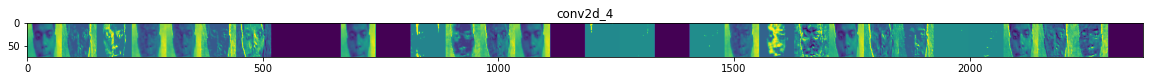

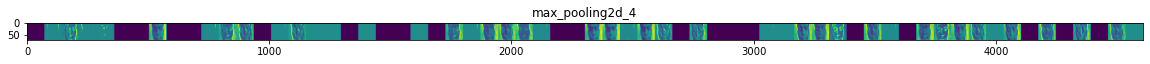

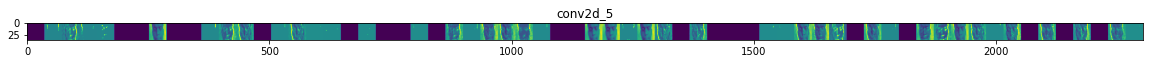

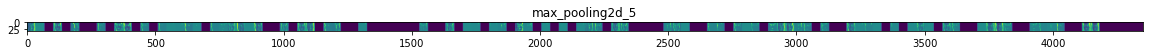

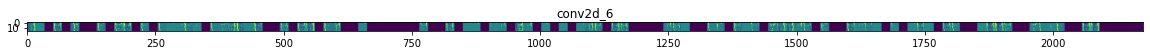

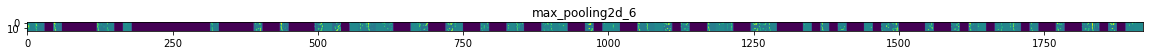

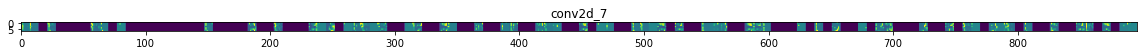

In [16]:
import matplotlib.pyplot as plt 
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
d_img_files = [os.path.join(d_dir, f) for f in d_img]
ud_img_files = [os.path.join(ud_dir, f) for f in ud_img]

img_path = random.choice(d_img_files + ud_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


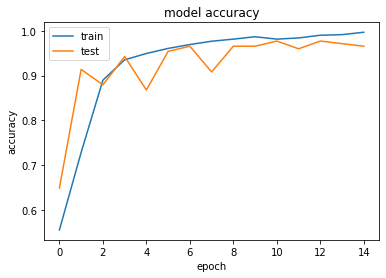

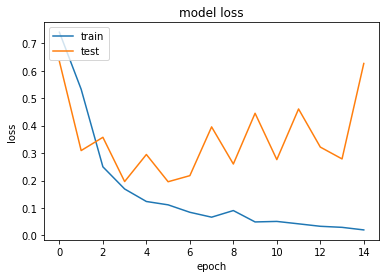

In [17]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model.save('model_30Nov_15epoch.h5')